In [1]:
import torch
from torch import nn
from torch import optim
import fastcore.all as fc
from datasets import load_dataset
from torch.utils.data import default_collate, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from functools import partial

In [2]:
name = 'fashion_mnist'
x,y = 'image','label'
dsr = load_dataset(name)

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 2/2 [00:00<00:00, 64.25it/s]


In [4]:
def transform(b):
    b[x] = [TF.to_tensor(ele) for ele in b[x]]
    return b

def collate_fn(b):
    clt = default_collate(b)
    return (clt[x], clt[y])

class DataLoaders:
    def __init__(self, train_ds, valid_ds, collate_fn, batch_size):
        self.train = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
        self.valid = DataLoader(valid_ds, batch_size=2*batch_size, collate_fn=collate_fn, shuffle=False)

In [5]:
batch_size = 64
dst = dsr.with_transform(transform)
dls = DataLoaders(dst['train'], dst['test'], batch_size=batch_size, collate_fn=collate_fn)

In [6]:
xb,yb = next(iter(dls.train))
xb.shape, yb.shape, xb.min(), xb.max()

(torch.Size([64, 1, 28, 28]), torch.Size([64]), tensor(0.), tensor(1.))

In [7]:
xbmean,xbstd = xb.mean(),xb.std()
xbmean,xbstd

(tensor(0.2833), tensor(0.3439))

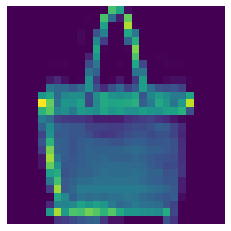

In [8]:
plt.imshow(xb[9].permute(1,2,0));
plt.axis('off');

In [9]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu' if not torch.cuda.is_available() else 'gpu'
device

'mps'

In [67]:
class Reshape(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.view(self.dim)

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dims = [32, 64, 128, 256, 512]
        self.encoder = self._encoder()
        self.decoder = self._decoder()
        self.en_mu = nn.Linear(self.hidden_dims[-1], latent_dim)
        self.en_var = nn.Linear(self.hidden_dims[-1], latent_dim)
    
    def _encoder(self):
        layers = []
        input_dim = 1
        for hdim in self.hidden_dims:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(input_dim, hdim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(hdim),
                    nn.LeakyReLU(1e-2), 
                )
            )
            input_dim = hdim
        return nn.Sequential(*layers)
       
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def _decoder(self):
        hidden_dims = self.hidden_dims.copy()
        hidden_dims.reverse()
        layers = [nn.Linear(self.latent_dim, self.hidden_dims[-1]), Reshape((-1, 512, 1, 1))]
        for i in range(len(hidden_dims)-1):
            layers.append(
               nn.Sequential(
                    nn.ConvTranspose2d(
                    hidden_dims[i],
                    hidden_dims[i+1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1
                ),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.LeakyReLU(1e-2),
               )
            )
        layers.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1], kernel_size=3, stride=4, padding=4),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(1e-2),
                nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=3, stride=2, padding=1),
                nn.Sigmoid()
            )
        )
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.en_mu(x)
        logvar = self.en_var(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar

In [68]:
m = VAE().to(device)
xb = xb.to(device)
o,*_ = m(xb)
o.shape

torch.Size([64, 1, 28, 28])

In [69]:
class ActStats:
    def __init__(self, m) :
        self.losses = []
        layers = []
        m.apply(lambda k: layers.append(k) if isinstance(k, (nn.Linear)) else None)
        for i,l in enumerate(layers):
            l.register_forward_hook(partial(self.track_stats, i))
        self.stds = [[] for _ in range(len(layers))]
        self.means = [[] for _ in range(len(layers))]
        self.hists = [[] for _ in range(len(layers))]
        self.lrs = []

    def track_stats(self, i, m, inp, outp):
        act = outp.detach().cpu()
        self.means[i].append(act.mean())
        self.stds[i].append(act.std())
        self.hists[i].append(act.abs().histc(40, 0, 10))
    
    def plot(self, figsize=(20, 5)):
        _,axs = plt.subplots(1, 4, figsize=figsize)
        titles = ['means', 'stds', 'losses', 'lrs']
        for title, data, ax in zip(titles, (self.means, self.stds, [self.losses], [self.lrs]), axs.flat):
            for i,l in enumerate(data):
                ax.plot(l, label=f'layer_{i}')
            ax.set_title(title)
            ax.legend()

    def plot_hist(self, figsize=(20, 5)):
        _,axs = plt.subplots(1, len(self.hists), figsize=figsize)
        for hist, ax in zip(self.hists, axs.flat):
            ax.imshow(torch.stack(hist).t().float().log1p(), origin='lower')
    
    def plot_dead_act(self, figsize=(20, 5)):
        _,axs = plt.subplots(1, len(self.hists), figsize=figsize)
        for hist, ax in zip(self.hists, axs.flat):
            zrs = torch.stack(hist).t().float()
            ax.plot(zrs[0]/zrs.sum(0))
            ax.set_ylim(0, 1)
    

In [70]:
def kaiming_init(m, leaky=1e-2):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight, a=leaky)

In [72]:
epochs = 20
kldweight = 0.00025
lr =  2e-4
model = VAE().to(device)
model.apply(kaiming_init)
actstats = ActStats(model)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, total_steps=epochs, max_lr=1e-2)
for epoch in range(epochs):
    dl = dls.train
    for xb,_ in dl:
        xb = xb.to(device)
        pred,mu,logvar = model(xb)
        reconstruction_loss = F.mse_loss(pred, xb)
        kl_divergence_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        loss = reconstruction_loss + kldweight * kl_divergence_loss
        loss.backward()
        opt.step()
        opt.zero_grad()
    sched.step()
    print(f'epoch:{epoch+1}, loss:{loss.item():.4f}')

epoch:1, loss:0.0303
epoch:2, loss:0.0244


In [ ]:
# actstats.plot_dead_act(figsize=(20, 4))
# actstats.plot(figsize=(20, 5))
# actstats.plot_hist(figsize=(20, 40))

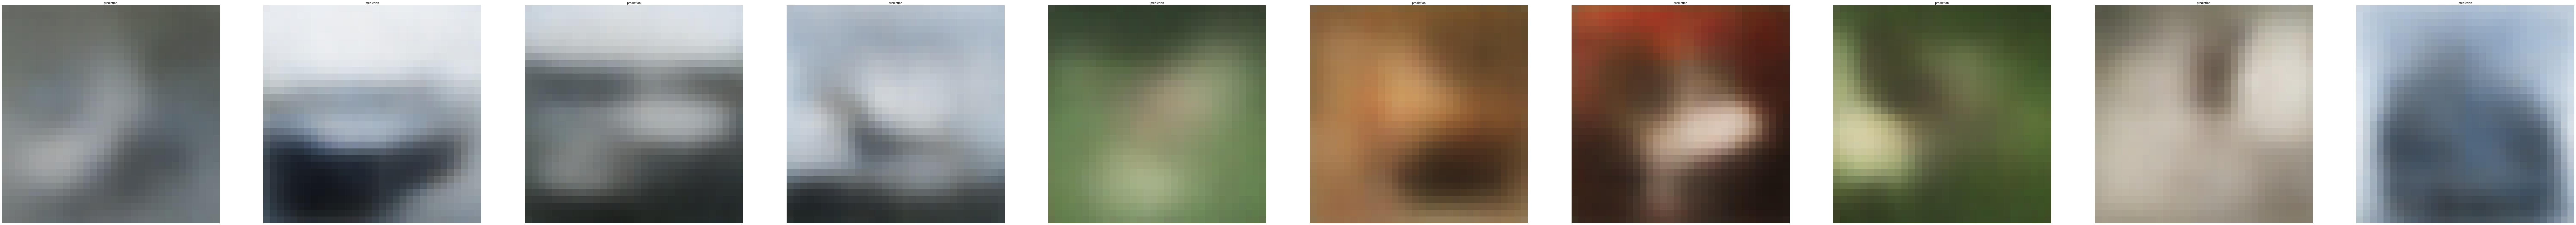

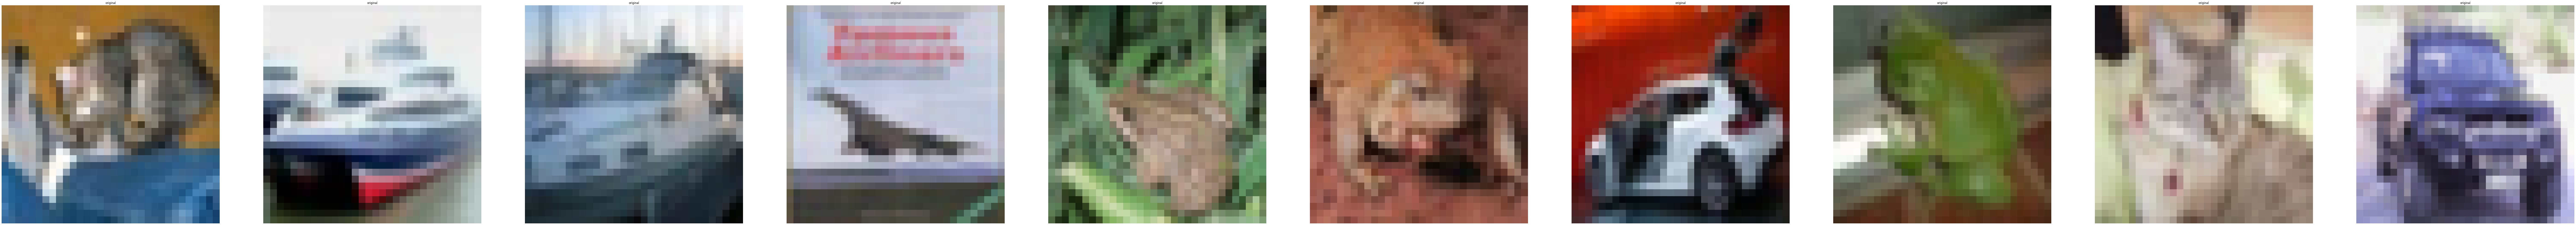

In [ ]:
xb,yb = next(iter(dls.valid))
xb = xb.to(device)
outp = model(xb)[0].detach().cpu()
sz = 10
imgs = outp[:sz]
imgs.shape
_,axs = plt.subplots(1, sz, figsize=(200, 200))
for img, ax in zip(imgs, axs.flat):
    ax.imshow(img.permute(1,2,0))
    ax.set_axis_off()
    ax.set_title('prediction')

xb = xb.detach().cpu()
_,axs2 = plt.subplots(1, sz, figsize=(200, 200))
for img, ax in zip(xb[:sz], axs2.flat):
    ax.imshow(img.permute(1,2,0))
    ax.set_axis_off()
    ax.set_title('original')

In [ ]:
zb = torch.randn((5, 10)).to(device)
zb = model.decoder(zb)
zb = zb.detach().cpu()
zb.shape
_,axs3 = plt.subplots(1, sz, figsize=(200, 200))
for img, ax in zip(zb, axs3.flat):
    ax.imshow(img.permute(1, 2, 0))
    ax.set_axis_off()
    ax.set_title('sample', fontsize=13)

: 